# Il modello lineare gerarchico {#sec-multilevel-model}

**Prerequisiti**

- Leggere [How statistical challenges and misreadings of the literature combine to produce unreplicable science: An example from psychology](https://osf.io/preprints/psyarxiv/ekmdf) di Andrew Gelman e Nicholas J. L. Brown.

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import warnings
warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "hierarchical_models"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione {.unnumbered}

I modelli multilivello rappresentano uno strumento statistico di fondamentale importanza in psicologia, capace di affrontare la complessità intrinseca di molti disegni sperimentali nel campo. Tuttavia, il loro utilizzo non è esente da insidie, come evidenziato in un recente studio di @gelman2024statistical.

La ricerca psicologica spesso si trova ad analizzare dati con strutture gerarchiche o nidificate: pensiamo alle misurazioni ripetute su singoli individui, alle manipolazioni sperimentali applicate a gruppi, o alle valutazioni fornite da diversi osservatori. In questi contesti, le domande di ricerca possono riguardare come una manipolazione influenzi un cambiamento, come gli effetti varino tra gruppi, o come l'impatto di una variabile dipenda dai livelli di un'altra. La variabilità interindividuale, inoltre, spinge spesso i ricercatori verso confronti intra-soggetto, sia per ragioni teoretiche che di efficienza statistica.

@gelman2024statistical mettono in luce due fattori critici che possono portare a un'eccessiva fiducia nelle conclusioni tratte da dati rumorosi, contribuendo così alla crisi di replicabilità in psicologia. Il primo fattore riguarda proprio la complessità dell'analisi di dati multilivello: è facile incorrere in falsi positivi dovuti a errori correlati, risulta difficile effettuare controlli di plausibilità su analisi complesse, e la modellazione multilivello introduce sfide interpretative specifiche.

Il secondo fattore critico concerne l'interpretazione della letteratura empirica. I risultati pubblicati tendono spesso a sovrastimare le dimensioni degli effetti, un fenomeno attribuibile alla bassa potenza statistica e alla selezione basata sulla significatività [@ioannidis2008most]. Inoltre, si riscontrano frequentemente discrepanze tra le affermazioni fatte e le evidenze empiriche a loro supporto.

Un esempio illuminante di queste problematiche emerge dalla ri-analisi condotta da @gelman2024statistical sui dati di @aungle2023physical. Applicando un modello statistico più appropriato, l'effetto originariamente riportato da @aungle2023physical scompare, evidenziando come l'uso inadeguato di modelli multilivello possa portare a conclusioni errate.

Alla luce di queste considerazioni, appare evidente l'importanza di una solida comprensione dei modelli multilivello per chi si occupa di ricerca psicologica. Questo capitolo si propone quindi di fornire un'introduzione a questa classe di modelli statistici, con l'obiettivo di dotare gli studenti degli strumenti necessari per navigare le complessità di questa specifica classe di analisi dei dati in psicologia.

## Concetti di base

I modelli multilivello affrontano una delle principali limitazioni del modello di regressione tradizionale: l'assunzione di indipendenza delle osservazioni. Nel modello di regressione classico, si presuppone che per ogni valore di $x$, le osservazioni $y$ siano campionate in modo indipendente dalla distribuzione $p(y \mid x)$. Ciò implica che gli errori $y_i - E(α + βx_i)$ siano tra loro indipendenti, una condizione garantita solo in specifici disegni di ricerca, come il campionamento casuale semplice. Tuttavia, numerosi disegni sperimentali in psicologia violano questa assunzione. È frequente, ad esempio, che lo stesso individuo venga osservato in diverse condizioni, generando una struttura di dati con osservazioni correlate o raggruppate (clustered).

I modelli ad effetti misti, o multilivello, sono stati sviluppati proprio per gestire queste situazioni complesse, rendendoli particolarmente adatti per i disegni a misure ripetute, così comuni nella ricerca psicologica. Questi modelli, conosciuti anche come modelli gerarchici, modelli ad effetti casuali o modelli nidificati, rappresentano un approccio efficace per l'analisi di dati organizzati in gruppi o livelli.

La versatilità dei modelli gerarchici si manifesta nella loro applicabilità a diverse tipologie di dati: geograficamente nidificati (ad esempio, dati di città all'interno di province, province all'interno di stati), organizzati gerarchicamente (come studenti all'interno di scuole o pazienti in ospedali), o implicanti misurazioni ripetute sugli stessi individui. Questa flessibilità consente di gestire le complessità intrinseche a tali dati, tenendo conto sia delle variazioni condivise che di quelle uniche tra i gruppi.

Un aspetto fondamentale dei modelli gerarchici è la loro capacità di facilitare la condivisione di informazioni tra i gruppi. Ciò avviene mediante l'impiego di distribuzioni priori per i parametri, influenzate a loro volta da distribuzioni priori di livello superiore, comunemente chiamate iperpriori. Il prefisso "iper" deriva dal termine greco per "sopra", indicando che queste distribuzioni priori operano a un livello superiore rispetto alle distribuzioni priori standard. Le distribuzioni degli iperparametri consentono al modello di equilibrare la descrizione delle caratteristiche specifiche dei gruppi con una descrizione delle tendenze comuni tra i gruppi.

La figura successiva illustra graficamente le differenze tra gli approcci dei modelli aggregati (dove i dati sono trattati come se provenissero da un unico gruppo), dei modelli non aggregati (dove ogni gruppo è trattato separatamente) e dei modelli gerarchici (o parzialmente aggregati), dove le informazioni sono condivise tra i gruppi.

![Le differenze tra un modello aggregato (pooled), un modello non aggregato (unpooled) e un modello gerarchico. (Figura tratta da @martin2024bayesian).](../../figures/hierarchical_model.png){width="70%"}

Nel contesto della regressione lineare gerarchica Bayesiana, l'utilizzo di librerie specializzate come Bambi facilita l'implementazione di questi modelli complessi. Questa metodologia si rivela particolarmente utile nell'analisi di dataset che comprendono diverse unità di osservazione, rappresentate dai soggetti, ciascuna delle quali è associata a multiple misurazioni.

Per una comprensione visiva più intuitiva dei modelli gerarchici, si consiglia di consultare il demo interattivo di Michael Freeman, accessibile [su questo sito](http://mfviz.com/hierarchical-models/).

## Complete Pooling, No Pooling, Partial Pooling

Nei capitoli precedenti, è stato introdotto il concetto di modellazione gerarchica bayesiana, con particolare attenzione alla stima dei parametri di distribuzioni di probabilità. Per un approfondimento su questo tema, si veda il @sec-stan-hier_beta_binom. Il presente capitolo si propone di estendere tale concetto alla stima dei parametri in un modello di regressione lineare, focalizzandosi sull'analisi di dati suddivisi in vari gruppi.

Nell'affrontare l'analisi di dati provenienti da gruppi eterogenei, si possono delineare tre principali approcci metodologici, ciascuno con peculiari vantaggi e limitazioni:

1. **Complete Pooling:** Questo modello prescinde dalla struttura gerarchica dei dati, trattando tutte le unità osservative come appartenenti a un'unica popolazione. Sebbene questo approccio possa incrementare la precisione delle stime attraverso l'aggregazione di tutti i dati, rischia di obliterare informazioni cruciali specifiche di ciascun gruppo, risultando potenzialmente eccessivamente generalizzante.
2. **No Pooling:** In antitesi al precedente, questo modello considera ogni gruppo come entità indipendente, ignorando qualsiasi struttura gerarchica. Questa metodologia, pur consentendo di evidenziare le peculiarità di ogni gruppo, può condurre a conclusioni meno robuste a causa della mancanza di un contesto più ampio e della potenziale scarsità di dati per singoli gruppi.
3. **Partial Pooling** (o Modello Multi-Livello): Rappresenta un approccio intermedio e più equilibrato. Questo modello presuppone che pendenze e intercette di ciascun gruppo siano realizzazioni di variabili casuali, distribuite normalmente con parametri di media e varianza condivisi tra tutti i gruppi. 

Il modello di "partial pooling" si distingue per la sua capacità di conciliare l'indipendenza dei gruppi con l'esigenza di un'analisi aggregata. Questa metodologia facilita un adeguato "shrinkage" dei parametri, attenuando l'impatto di valori anomali o di gruppi con campioni limitati. Consente inoltre alle stime parametriche di ogni gruppo di essere influenzate sia dai dati specifici che dalla tendenza generale osservata nei dati aggregati.

L'analisi gerarchica, incarnata nel modello di partial pooling, offre quindi un compromesso ottimale tra gli approcci di complete pooling e no pooling, sintetizzando i benefici di entrambe le metodologie. Questo approccio permette di preservare le informazioni specifiche di ciascun gruppo, mantenendo al contempo una visione d'insieme che migliora la robustezza e l'accuratezza delle stime.

## EDA

Iniziamo importando i dati e ispezionando la struttura delle osservazioni suddivise nei diversi cluster. 

In [3]:
data = bmb.load_data("sleepstudy")
data.head()

Reaction  Days  Subject
0  249.5600     0      308
1  258.7047     1      308
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308

Eliminiamo le righe in cui la colonna "Days" ha valore 0 o 1 dal dataset "sleepstudy" utilizzando il seguente codice:

In [4]:
data = data[data['Days'].isin([0, 1]) == False]
data.head()

Reaction  Days  Subject
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308
5  414.6901     5      308
6  382.2038     6      308

Analizziamo il tempo di reazione medio in relazione ai giorni di deprivazione del sonno, osservando come questo varia per ciascun soggetto coinvolto nello studio.

In [5]:
def plot_data(data):
    fig, axes = plt.subplots(3, 6, sharey=True, sharex=True, dpi=100, constrained_layout=True)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="#B17F7D", ec="#832F2B", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=9)

    # Remove axis labels for individual plots
    for ax in axes_flat:
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Set x-axis ticks for the last row
    for ax in axes[-1]:
        ax.xaxis.set_ticks([0, 2, 4, 6, 8])

    return axes

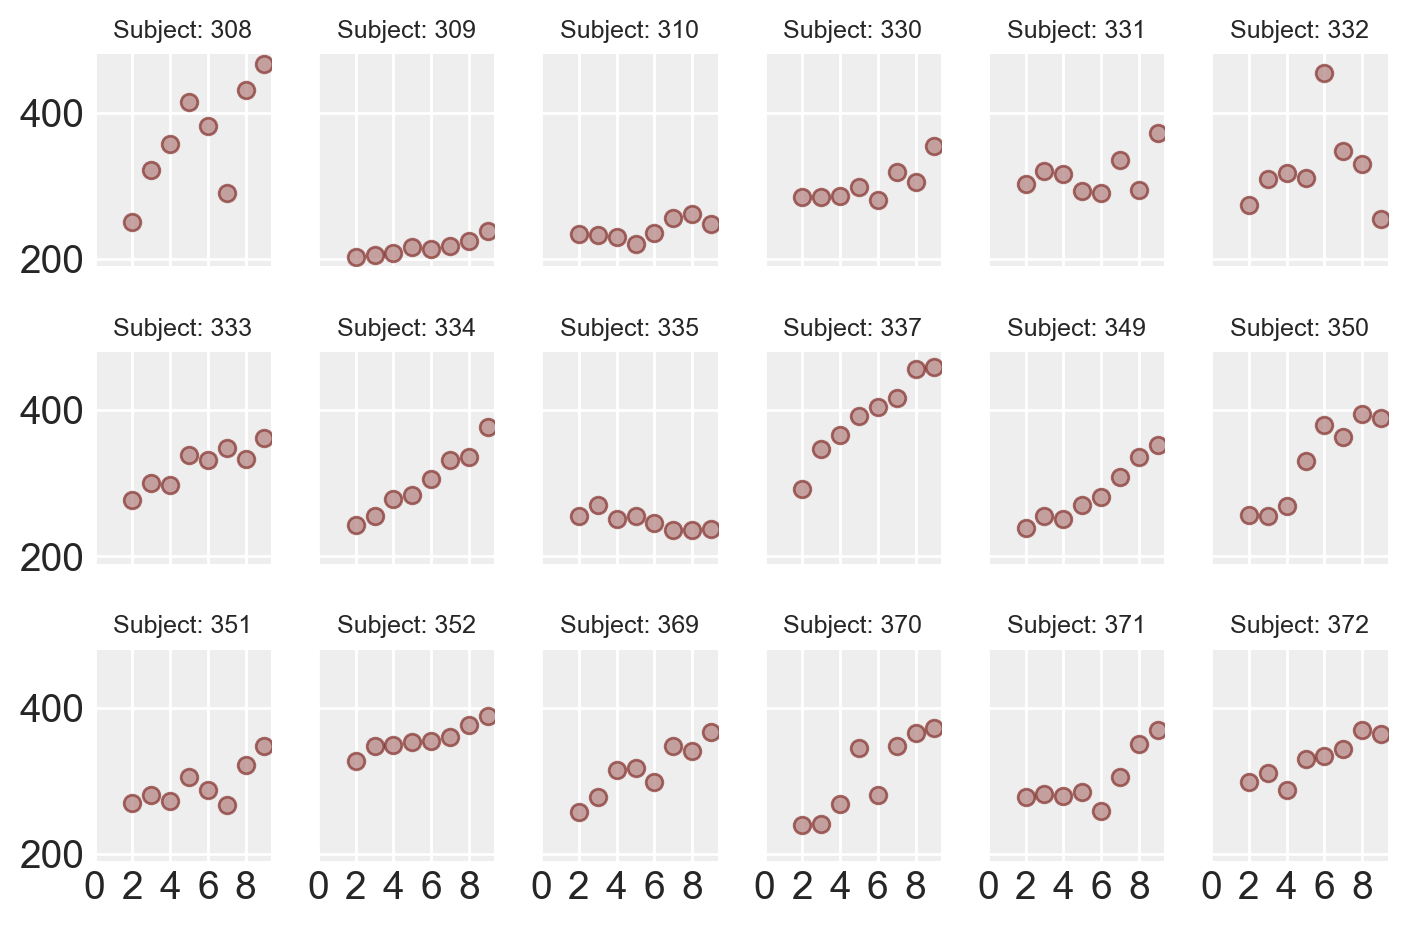

In [6]:
plot_data(data)
plt.tight_layout()

## Modello complete pooling

Il modello complete pooling tratta tutte le osservazioni come se fossero indipendenti, aggregandole in un unico gruppo. In questo modello, le rette di regressione lineare per tutti i soggetti hanno la stessa pendenza e la stessa intercetta. Il modello può essere descritto esplicitamente come segue:

Se disponiamo di $ m $ soggetti e ciascun soggetto $ i $ ha $ n_i $ osservazioni, il modello può essere definito da:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m, \text{ e per l'osservazione } j = 1, \ldots, n_i:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha + \beta \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2),
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione per il soggetto $ i $ al giorno $ j $.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $ i $ all'osservazione $ j $.
- $\alpha$ è l'intercetta comune a tutti i soggetti.
- $\beta$ è la pendenza comune a tutti i soggetti.
- $\epsilon_{ij}$ è il termine di errore casuale per il soggetto $ i $ all'osservazione $ j $, che si suppone sia distribuito normalmente con media 0 e varianza costante $ \sigma^2 $.

Questo modello non distingue tra i gruppi di osservazoni che appartengono a soggetti diversi e stima un'unica pendenza e un'unica intercetta dai dati di tutti i soggetti. In Bambi, questo modello può essere specificato utilizzando solo la variabile `Days` come predittore, senza includere il `Subject` come fattore.

In [7]:
model_pooling = bmb.Model("Reaction ~ 1 + Days", data)

Procediamo con l'esecuzione del campionamento MCMC, utilizzando il metodo NUTS specifico per il campionatore JAX. Questo può essere fatto semplicemente passando l'opzione `method="nuts_numpyro"` durante la chiamata al campionamento. In questo modo, stiamo invocando direttamente il campionatore JAX, sfruttando le sue caratteristiche avanzate.

In [8]:
results_pooling = model_pooling.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

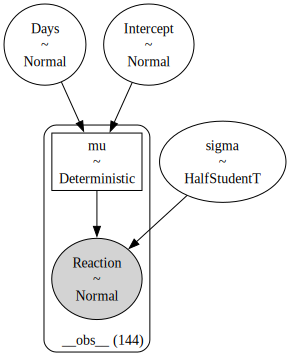

In [10]:
model_pooling.build()
model_pooling.graph()

Un sommario numerico delle distribuzioni a posteriori dei parametri si ottiene con `az.summary`.

In [11]:
az.summary(results_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Days        11.40   1.88    7.89    14.88       0.03     0.02   3826.84   
Intercept  245.15  11.22  224.18   266.21       0.18     0.13   3871.91   
sigma       51.10   3.03   45.52    56.72       0.05     0.04   3277.56   

           ess_tail  r_hat  
Days        2982.56    1.0  
Intercept   2719.25    1.0  
sigma       2502.12    1.0

## Modello no-pooling

Il modello no-pooling tratta ogni soggetto come indipendente e adatta una retta di regressione  separata per ciascun soggetto. Se disponiamo di $ m $ soggetti e ciascun soggetto $ i $ ha $ n_i $ osservazioni, il modello può essere definito da:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha_i + \beta_i \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2), \quad j = 1, \ldots, n_i,
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione per il soggetto $ i $ al giorno $ j $.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $ i $ all'osservazione $ j $.
- $\alpha_i$ è l'intercetta per il soggetto $ i $.
- $\beta_i$ è la pendenza per il soggetto $ i $.
- $\epsilon_{ij}$ è il termine di errore casuale per il soggetto $ i $ all'osservazione $ j $, che si suppone sia distribuito normalmente con media 0 e varianza costante $ \sigma^2 $.

Questo modello non fa alcuna ipotesi sulle relazioni tra diversi soggetti e stima la pendenza e l'intercetta di ciascun soggetto indipendentemente dagli altri soggetti. In Bambi, questo modello viene specificato con l'interazione tra `Days` e `Subject`, come descritto in seguito.

In [12]:
model_no_pooling = bmb.Model("Reaction ~ Days * C(Subject)", data=data)
results_no_pooling = model_no_pooling.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


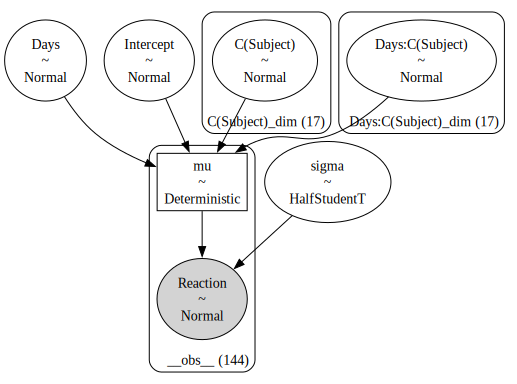

In [13]:
model_no_pooling.build()
model_no_pooling.graph()

In [14]:
az.summary(results_no_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
C(Subject)[309]       -55.81  32.73 -117.09     3.39       1.47     1.05   
C(Subject)[310]       -29.49  32.66  -91.81    30.77       1.52     1.08   
C(Subject)[330]         9.81  33.06  -54.38    70.30       1.60     1.13   
C(Subject)[331]        40.59  33.14  -17.89   104.88       1.65     1.17   
C(Subject)[332]        63.12  33.24    3.03   130.72       1.57     1.11   
C(Subject)[333]        15.92  32.92  -47.16    75.49       1.46     1.03   
C(Subject)[334]       -45.95  32.49 -105.15    14.85       1.75     1.24   
C(Subject)[335]        23.44  32.25  -36.55    82.48       1.42     1.01   
C(Subject)[337]        19.76  33.12  -45.71    77.39       1.63     1.15   
C(Subject)[349]       -51.58  32.86 -111.09    10.94       1.57     1.11   
C(Subject)[350]       -46.21  32.82 -111.98    13.33       1.57     1.11   
C(Subject)[351]        -0.91  33.30  -63.92    58.14       1.45     1.03   
C(Subject)[352]        68.96  32.63    3.34   127.98       1.47     1.04   
C(Subject)[369]        -8.53  32.77  -70.04    54.41       1.46     1.03   
C(Subject)[370]       -54.17  32.62 -116.74     5.41       1.59     1.12   
C(Subject)[371]       -14.22  32.78  -71.89    50.01       1.54     1.09   
C(Subject)[372]        20.63  33.07  -37.39    84.62       1.60     1.13   
Days                   21.21   3.81   13.66    27.95       0.28     0.20   
Days:C(Subject)[309]  -16.90   5.49  -27.16    -6.56       0.23     0.16   
Days:C(Subject)[310]  -17.32   5.46  -27.41    -6.81       0.26     0.19   
Days:C(Subject)[330]  -13.25   5.57  -24.32    -3.22       0.26     0.18   
Days:C(Subject)[331]  -16.33   5.54  -26.02    -5.47       0.27     0.19   
Days:C(Subject)[332]  -18.75   5.52  -29.33    -8.71       0.25     0.18   
Days:C(Subject)[333]  -10.31   5.50  -20.58    -0.35       0.25     0.17   
Days:C(Subject)[334]   -3.09   5.41  -13.47     6.89       0.30     0.21   
Days:C(Subject)[335]  -25.37   5.36  -34.91   -14.87       0.24     0.17   
Days:C(Subject)[337]    1.31   5.57   -9.40    11.36       0.26     0.18   
Days:C(Subject)[349]   -4.81   5.55  -15.64     5.20       0.24     0.17   
Days:C(Subject)[350]    2.10   5.55   -8.33    12.57       0.26     0.19   
Days:C(Subject)[351]  -12.67   5.52  -22.70    -2.30       0.24     0.17   
Days:C(Subject)[352]  -13.89   5.50  -23.87    -3.04       0.26     0.19   
Days:C(Subject)[369]   -7.43   5.45  -18.21     2.41       0.24     0.17   
Days:C(Subject)[370]   -0.55   5.51  -10.04    10.55       0.26     0.18   
Days:C(Subject)[371]   -8.90   5.52  -18.74     1.63       0.26     0.18   
Days:C(Subject)[372]  -10.04   5.57  -20.17     0.46       0.26     0.18   
Intercept             247.65  22.86  205.21   291.61       1.55     1.11   
sigma                  25.75   1.79   22.47    29.03       0.03     0.02   

                      ess_bulk  ess_tail  r_hat  
C(Subject)[309]         498.93   1286.54   1.01  
C(Subject)[310]         457.16   1208.49   1.02  
C(Subject)[330]         424.43   1467.19   1.02  
C(Subject)[331]         402.96   1460.16   1.02  
C(Subject)[332]         454.04   1248.37   1.01  
C(Subject)[333]         489.51   1451.70   1.02  
C(Subject)[334]         343.16   1366.32   1.02  
C(Subject)[335]         513.56   1550.53   1.02  
C(Subject)[337]         414.59   1451.97   1.02  
C(Subject)[349]         437.61   1557.00   1.02  
C(Subject)[350]         439.14   1107.06   1.02  
C(Subject)[351]         532.34   1525.08   1.02  
C(Subject)[352]         494.89   1325.51   1.02  
C(Subject)[369]         502.71   1346.09   1.01  
C(Subject)[370]         423.29   1338.47   1.02  
C(Subject)[371]         453.79   1263.58   1.01  
C(Subject)[372]         426.34   1288.41   1.02  
Days                    190.54    654.98   1.03  
Days:C(Subject)[309]    563.01   1286.88   1.01  
Days:C(Subject)[310]    436.01   1175.22   1.02  
Days:C(Subject)[330]    454.06   1477.08   1.01  
Days:C(Subject)[331]    431.51   10

Per ricavare i coefficienti $\alpha$ delle regressioni individuali, dobbiamo sommare `Intercept` al valore del singolo soggetto. Per esempio, per il soggetto 309 abbiamo

In [14]:
246.98 + -55.29

191.69

Facciamo lo stesso per la pendenza individuale delle rette di regressione. Per il soggetto 309 otteniamo

In [15]:
21.30 + -16.97

4.330000000000002

Questi valori sono identici a quelli che si otterrebbero se adattassimo il modello di regressione separatamente per ciascun soggetto. In effetti, abbiamo fatto proprio questo, utilizzando un modello unico. Per esempio, esaminiamo i singoli dati del soggetto 309.

In [13]:
data_subject_309 = data[data["Subject"] == 309]
data_subject_309.shape

(8, 3)

Stimiamo l'intercetta e la pendenza della retta di regressione usando l'approccio frequentista mediante la funzione `linear_regression` del pacchetto `pingouin`.

In [14]:
result = pg.linear_regression(data_subject_309["Days"], data_subject_309["Reaction"])
print(result)

       names        coef        se          T          pval        r2  \
0  Intercept  191.576970  3.723259  51.454104  3.615788e-09  0.890144   
1       Days    4.357144  0.624898   6.972569  4.325982e-04  0.890144   

     adj_r2    CI[2.5%]   CI[97.5%]  
0  0.871834  182.466483  200.687458  
1  0.871834    2.828074    5.886214  


Si noti che i risultati ottenuti sono sostanzialmente gli stessi, con solo qualche minima differenza numerica. Questa discrepanza deriva dalla diversità degli approcci utilizzati: in un caso abbiamo applicato un metodo bayesiano, mentre nell'altro abbiamo adottato una tecnica di stima frequentista.

## Modello partial pooling

Il modello gerarchico, conosciuto anche come modello di "partial pooling", consente di gestire la complessità presente nei dati raggruppati o clusterizzati, come nel caso presente. La regressione lineare classica presume che ogni osservazione sia indipendente dalle altre, ma questa ipotesi viene meno quando i dati sono organizzati in gruppi. Le osservazioni all'interno dello stesso gruppo tendono ad essere più correlate tra loro rispetto a quelle in gruppi diversi. Trascurare questa struttura gerarchica potrebbe portare a stime errate e conclusioni fuorvianti.

Il modello gerarchico affronta questo problema introducendo la nozione di effetti casuali, in contrapposizione agli effetti fissi del modello classico. Gli effetti fissi rappresentano l'effetto medio di una variabile predittiva su tutti gli individui o gruppi, mentre gli effetti casuali considerano come l'effetto di una variabile possa variare da un gruppo all'altro. Mentre gli effetti fissi sono comuni a tutto il dataset, gli effetti casuali tengono conto delle differenze tra i gruppi.

Questo modello gerarchico unisce effetti fissi e casuali per fornire una rappresentazione più accurata dei dati, quando questi mostrano relazioni gerarchiche o raggruppate. Il modello gerarchico di "partial pooling" considera le somiglianze tra i soggetti stimando un'intercetta e una pendenza comuni, ma consente anche variazioni individuali attorno a questi valori medi.

Possiamo rappresentare matematicamente il modello come segue:

$$
\begin{align*}
\text{Per il soggetto } i = 1, \ldots, m, \text{ e per l'osservazione } j = 1, \ldots, n_i:
\end{align*}
$$

$$
\begin{align*}
\text{Reaction}_{ij} &= \alpha_i + \beta_i \cdot \text{Days}_{ij} + \epsilon_{ij}, \\
\epsilon_{ij} &\sim \mathcal{N}(0, \sigma^2),
\end{align*}
$$

dove:

- $\text{Reaction}_{ij}$ è il tempo di reazione del soggetto $i$ al giorno $j$.
- $\text{Days}_{ij}$ è il numero di giorni per il soggetto $i$ all'osservazione $j$.
- $\alpha_i$ è l'intercetta per il soggetto $i$, che segue la distribuzione $\alpha_i \sim \mathcal{N}(\alpha, \tau_\alpha^2)$.
- $\beta_i$ è la pendenza per il soggetto $i$, che segue la distribuzione $\beta_i \sim \mathcal{N}(\beta, \tau_\beta^2)$.
- $\epsilon_{ij}$ è l'errore casuale per il soggetto $i$ all'osservazione $j$, distribuito normalmente con media 0 e varianza costante $\sigma^2$.

I parametri $\alpha$ e $\beta$ rappresentano l'intercetta e la pendenza medie per tutti i soggetti, e le varianze $\tau_\alpha^2$ e $\tau_\beta^2$ quantificano le differenze tra gli individui.

In questo modo, il modello gerarchico riesce a rappresentare sia le informazioni comuni a tutti i soggetti, sia le differenze individuali, considerando sia gli effetti fissi che quelli casuali. Può quindi offrire una visione più completa e realistica dei dati, tenendo conto della loro struttura gerarchica. In Bambi, questo modello può essere specificato utilizzando la variabile `Days` come predittore e includendo `Subject` come effetto casuale.

In [15]:
model_partial_pooling = bmb.Model(
    "Reaction ~ 1 + Days + (Days | Subject)", data, categorical="Subject"
)

Eseguiamo il campionamento.

In [16]:
results_partial_pooling = model_partial_pooling.fit(
    nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

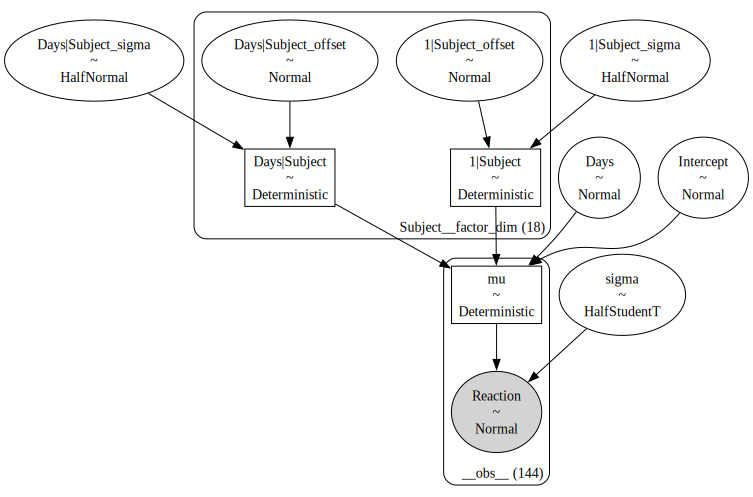

In [17]:
model_partial_pooling.build()
model_partial_pooling.graph()

Esaminiamo i risultati.

In [18]:
az.summary(results_partial_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Subject[308]       10.02  18.26  -23.88    45.32       0.30     0.24   
1|Subject[309]      -43.21  20.82  -81.90    -2.40       0.37     0.26   
1|Subject[310]      -25.98  19.01  -60.23    10.11       0.34     0.24   
1|Subject[330]        4.68  17.93  -28.33    39.60       0.28     0.25   
1|Subject[331]       22.05  18.80  -12.81    57.32       0.32     0.24   
1|Subject[332]       34.64  19.83   -1.54    71.69       0.38     0.27   
1|Subject[333]       11.22  18.56  -22.97    47.30       0.28     0.24   
1|Subject[334]      -22.66  18.29  -55.72    13.01       0.33     0.25   
1|Subject[335]        1.42  18.81  -33.38    37.33       0.33     0.28   
1|Subject[337]       26.62  19.63   -9.98    63.52       0.31     0.25   
1|Subject[349]      -27.94  19.23  -68.63     4.02       0.33     0.24   
1|Subject[350]      -17.37  19.44  -54.77    19.69       0.33     0.25   
1|Subject[351]       -2.22  18.12  -35.17    33.75       0.29     0.26   
1|Subject[352]       43.03  19.80    3.35    78.09       0.40     0.28   
1|Subject[369]       -2.06  18.31  -35.31    32.90       0.31     0.26   
1|Subject[370]      -25.09  18.76  -58.40    10.74       0.34     0.26   
1|Subject[371]       -7.11  18.62  -45.12    24.89       0.30     0.26   
1|Subject[372]       15.17  18.60  -20.32    50.26       0.30     0.24   
1|Subject_sigma      31.56   9.02   16.45    50.30       0.24     0.17   
Days                 11.50   1.93    7.87    15.22       0.05     0.04   
Days|Subject[308]     8.10   3.28    2.23    14.54       0.07     0.05   
Days|Subject[309]    -8.34   3.67  -15.35    -1.50       0.07     0.06   
Days|Subject[310]    -7.38   3.41  -13.66    -0.92       0.07     0.05   
Days|Subject[330]    -2.28   3.30   -8.32     4.07       0.07     0.05   
Days|Subject[331]    -3.20   3.36   -9.57     2.86       0.07     0.05   
Days|Subject[332]    -4.02   3.54  -10.46     2.85       0.08     0.05   
Days|Subject[333]     0.46   3.34   -6.16     6.42       0.07     0.05   
Days|Subject[334]     3.18   3.30   -3.22     9.10       0.07     0.05   
Days|Subject[335]   -11.26   3.48  -18.02    -4.83       0.07     0.05   
Days|Subject[337]     9.74   3.53    2.88    16.27       0.06     0.05   
Days|Subject[349]     1.56   3.39   -4.91     7.90       0.07     0.05   
Days|Subject[350]     7.23   3.41    0.87    13.50       0.07     0.05   
Days|Subject[351]    -2.24   3.26   -7.88     4.24       0.06     0.05   
Days|Subject[352]     0.18   3.47   -6.29     6.87       0.08     0.05   
Days|Subject[369]     1.52   3.29   -4.94     7.61       0.07     0.05   
Days|Subject[370]     4.78   3.31   -1.58    10.65       0.07     0.05   
Days|Subject[371]     0.05   3.33   -6.09     6.48       0.06     0.05   
Days|Subject[372]     0.77   3.41   -5.43     7.29       0.07     0.05   
Days|Subject_sigma    6.89   1.64    4.07     9.97       0.04     0.03   
Intercept           245.40   9.34  228.41   262.89       0.18     0.12   
sigma                26.06   1.84   22.59    29.37       0.03     0.02   

                    ess_bulk  ess_tail  r_hat  
1|Subject[308]       3801.21   3296.70    1.0  
1|Subject[309]       3192.01   2770.58    1.0  
1|Subject[310]       3180.64   2886.98    1.0  
1|Subject[330]       4049.42   3086.98    1.0  
1|Subject[331]       3416.40   2908.07    1.0  
1|Subject[332]       2774.25   2704.53    1.0  
1|Subject[333]       4343.31   3323.77    1.0  
1|Subject[334]       3106.34   2785.24    1.0  
1|Subject[335]       3188.72   2799.45    1.0  
1|Subject[337]       4073.78   2966.54    1.0  
1|Subject[349]       3381.72   3363.24    1.0  
1|Subject[350]       3549.86   2998.39    1.0  
1|Subject[351]       3981.53   3361.50    1.0  
1|Subject[352]       2495.13   2423.89    1.0  
1|Subject[369]       3570.39   2953.34    1.0  
1|Subject[370]       3062.92   3093.42    1.0  
1|Subject[371]       3873.47   3069.79    1.0  
1|Subject[372]       3831.96   3202.78    1.0  
1

Consideriamo il soggetto 309. Per questo soggetto l'intercetta è

In [22]:
245.24 + -42.22

203.02

e la pendenza della retta di regressione è

In [23]:
11.34 + -8.27

3.0700000000000003

Si noti che questi valori sono diversi da quelli ottenuti con la procedura di no-pooling. Entrambi i modelli di no pooling e il modello gerarchico di partial pooling riconoscono che ci possono essere differenze tra i diversi gruppi (o soggetti) nel dataset, ma gestiscono queste differenze in modi diversi.

Nel modello di no pooling, ogni gruppo viene trattato in modo completamente indipendente dagli altri. Ogni intercetta e pendenza viene stimata separatamente per ogni gruppo, senza fare riferimento agli altri gruppi. In altre parole, si adatta una regressione lineare separata per ciascun gruppo. Ciò significa che se si hanno molti gruppi, ci saranno molti parametri da stimare.

Questo approccio può catturare le differenze tra i gruppi molto accuratamente se ci sono molte osservazioni in ogni gruppo, ma può essere problematico se ci sono poche osservazioni per gruppo. Inoltre, non sfrutta le informazioni comuni tra i gruppi e può portare a stime molto variabili.

Il modello gerarchico di partial pooling, invece, riconosce che, anche se ci sono differenze tra i gruppi, questi potrebbero condividere alcune caratteristiche comuni. Invece di stimare le intercette e pendenze completamente separatamente per ogni gruppo, il modello gerarchico stima una media comune e una varianza comune per l'intercetta e la pendenza, e poi consente a ciascun gruppo di variare attorno a questi valori comuni.

Questo porta al concetto di "shrinkage". Le stime delle intercette e pendenze per ciascun gruppo tendono a essere "compresse" verso i valori medi. Se un gruppo ha poche osservazioni, la sua stima sarà più fortemente influenzata dalla media comune. Se ha molte osservazioni, la sua stima sarà meno influenzata dalla media comune. In questo modo, il modello riesce a bilanciare tra due tendenze opposte: rendere conto delle differenze tra i gruppi e sfruttare le informazioni comuni.

In sintesi, la differenza principale tra il modello no-pooling e il modello gerarchico partial-pooling sta nel modo in cui gestiscono le intercette e pendenze individuali:

- Il modello no-pooling tratta ogni gruppo separatamente, stimando le intercette e pendenze individuali senza considerare gli altri gruppi.
- Il modello gerarchico partial-pooling stima le intercette e pendenze comuni e consente a ciascun gruppo di variare attorno a questi valori comuni, dando luogo al fenomeno dello shrinkage.

Il modello di no pooling può essere più adatto se i gruppi sono veramente indipendenti e molto diversi tra loro, mentre il modello gerarchico è maggiormente appropriato quando ci sono somiglianze tra i gruppi che possono essere sfruttate per ottenere stime più precise e robuste.


### Modello Gerarchico e Distribuzione dei Coefficienti

In un contesto di modello gerarchico con partial pooling, gli effetti casuali, inclusi intercette e pendenze specifiche per ciascun gruppo o individuo, vengono trattati come esiti di variabili aleatorie. Questo approccio si distingue nettamente da quello adottato nei modelli di no pooling, nei quali ciascun coefficiente viene considerato come un parametro statico e indipendente.

All'interno di un modello gerarchico, l'assunzione di base è che questi effetti casuali siano distribuiti normalmente. Ciò implica che ogni coefficiente specifico di un gruppo o individuo (come l'intercetta per un dato soggetto) è visto come una manifestazione di una variabile aleatoria che segue una distribuzione normale. La distribuzione di queste variabili aleatorie, che rappresenta la popolazione degli effetti casuali, è caratterizzata da una media e una varianza condivise tra tutti i gruppi o soggetti, le quali vengono inferite direttamente dai dati raccolti. Questo permette di modellare la variabilità intra-gruppo e inter-gruppo in modo più flessibile e informato, offrendo una rappresentazione più accurata della struttura dei dati e delle relazioni sottostanti.

Ad esempio, le intercette individuali $\alpha_i$ possono essere modellate come:

$$
\alpha_i \sim \mathcal{N}(\alpha, \tau_\alpha^2),
$$

dove $\alpha$ è l'intercetta media per tutti i soggetti e $\tau_\alpha^2$ è la varianza delle intercette tra i soggetti. Analogamente, le pendenze individuali $\beta_i$ possono essere modellate come:

$$
\beta_i \sim \mathcal{N}(\beta, \tau_\beta^2),
$$

dove $\beta$ è la pendenza media e $\tau_\beta^2$ è la varianza delle pendenze.

### Implicazioni

Questa struttura ha diverse implicazioni importanti:

1. **Shrinkage:** Come discusso in precedenza, le stime dei coefficienti individuali tendono a essere "compresse" verso i valori medi. Questo aiuta a stabilizzare le stime, specialmente quando ci sono poche osservazioni per gruppo.

2. **Scambio di informazioni tra i gruppi:** Poiché i coefficienti individuali sono considerati come estratti dalla stessa distribuzione, ciò permette uno scambio di informazioni tra i gruppi. Se un gruppo ha molte osservazioni, può aiutare a informare le stime per un gruppo con poche osservazioni.

3. **Interpretazione gerarchica:** Il modello riconosce una struttura gerarchica nei dati, con osservazioni raggruppate all'interno di gruppi, e gruppi che condividono caratteristiche comuni. Questa struttura può riflettere una realtà sottostante nella quale gli individui o i gruppi non sono completamente indipendenti l'uno dall'altro.

In conclusione, il modello gerarchico di partial-pooling offre un quadro flessibile e potente per analizzare dati raggruppati o clusterizzati, riconoscendo sia le somiglianze che le differenze tra i gruppi e utilizzando una struttura probabilistica per modellare le relazioni tra di loro.

## Interpretazione

Iniziamo considerando le stime a posteriori degli effetti fissi.

In [19]:
az.summary(results_partial_pooling, var_names=["Intercept", "Days"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  245.4  9.34  228.41   262.89       0.18     0.12   2855.59   
Days        11.5  1.93    7.87    15.22       0.05     0.04   1283.13   

           ess_tail  r_hat  
Intercept   2917.47    1.0  
Days        1993.22    1.0

In media, il tempo di reazione medio delle persone all'inizio dello studio è compreso tra 227 e 264 millisecondi. Con ogni giorno aggiuntivo di privazione del sonno, i tempi di reazione medi aumentano, in media, tra 7.9 e 15.1 millisecondi.

L'interpretazione degli effetti fissi è semplice. Ma quest'analisi sarebbe incompleta e fuorviante se non valutiamo i termini specifici per i singoli soggetti che abbiamo aggiunto al modello. Questi termini ci dicono quanto i soggetti differiscono l'uno dall'altro in termini di tempo di reazione iniziale e dell'associazione tra giorni di privazione del sonno e tempi di reazione.

Di seguito, utilizziamo ArviZ per ottenere un traceplot delle intercetti specifiche per i soggetti `1|Subject` e delle pendenze `Days|Subject`. Questo traceplot contiene due colonne. A sinistra, abbiamo le distribuzioni posteriori e a destra abbiamo i trace-plots. L'aspetto casuale stazionario, o l'apparenza di rumore bianco, ci dice che il campionatore ha raggiunto la convergenza e le catene sono ben mescolate.

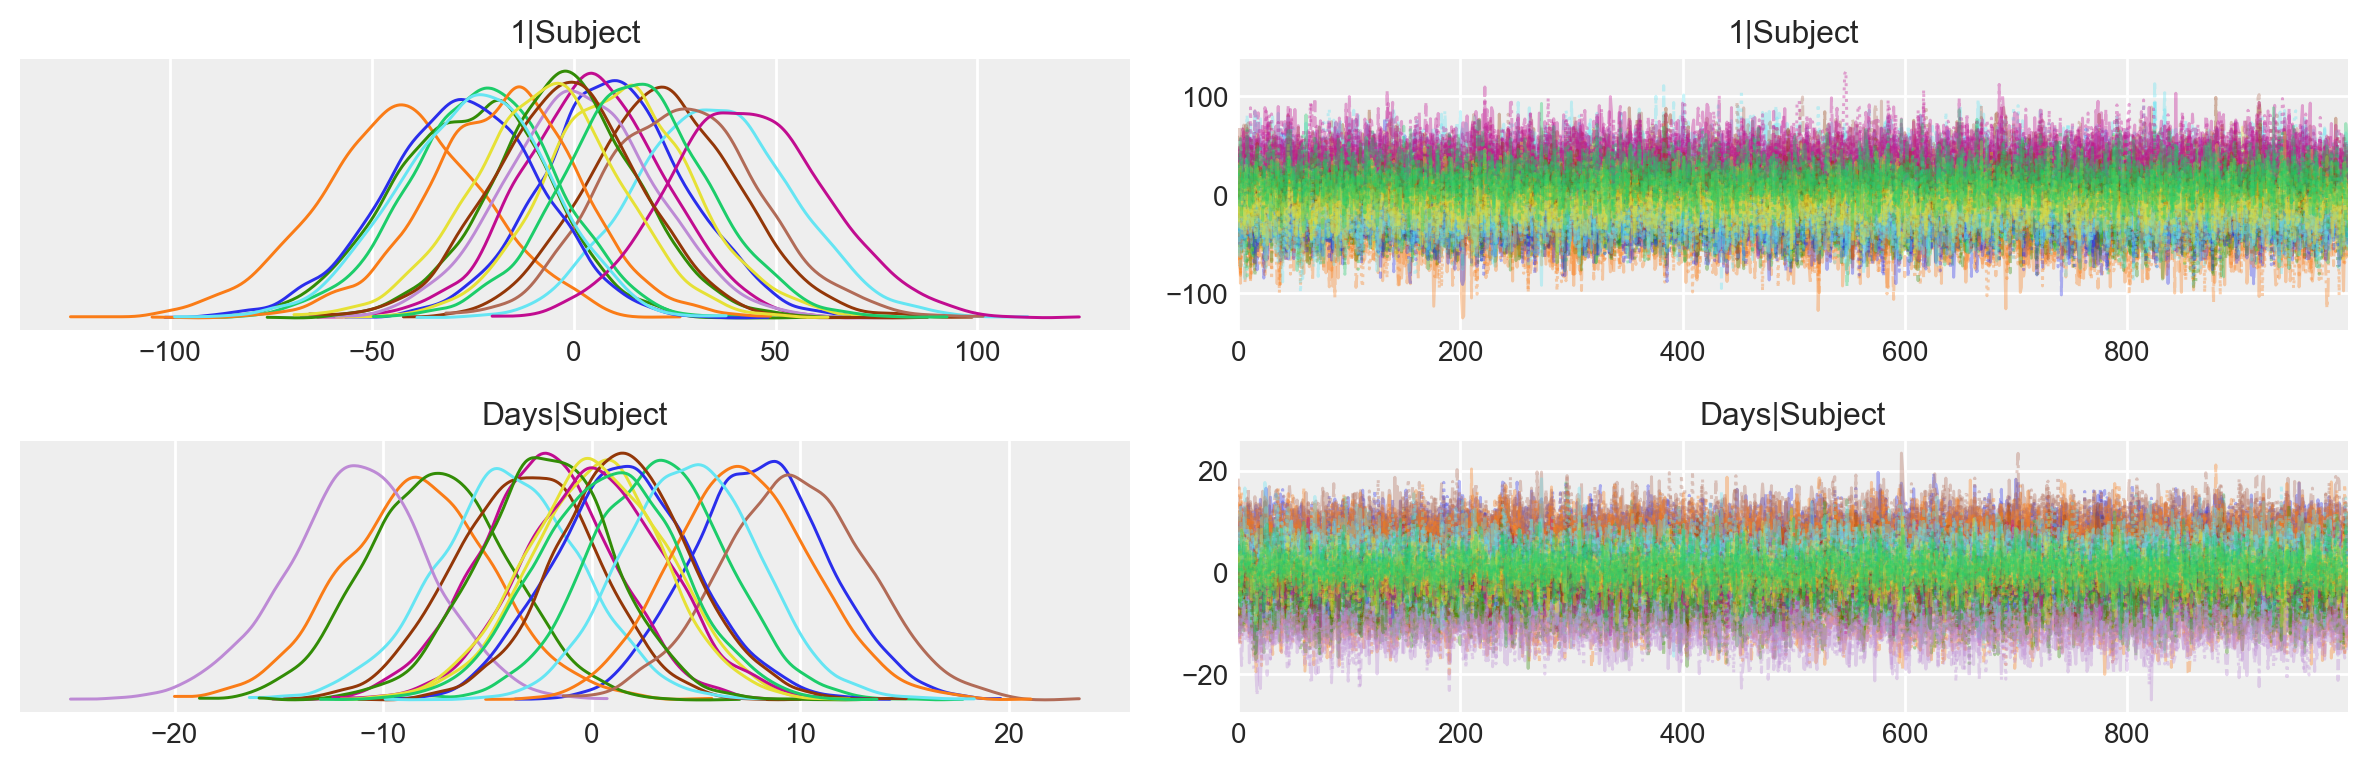

In [20]:
az.plot_trace(
    results_partial_pooling, combined=True, var_names=["1|Subject", "Days|Subject"]
)
plt.tight_layout()

Dall'ampiezza delle distribuzioni a posteriori delle intercette per i singoli soggetti possiamo vedere che il tempo di reazione medio iniziale per un determinato soggetto può differire notevolmente dalla media generale che abbiamo visto nella tabella precedente. C'è anche una grande differenza nelle pendenze. Alcuni soggetti vedono aumentare rapidamente i loro tempi di reazione quando vengono deprivati del sonno, mentre altri hanno una tolleranza migliore e peggiorano più lentamente. 

Una rappresentazione grafica della stima a posteriore dei parametri e dei dati si ottiene con `az.plot_forest()`.

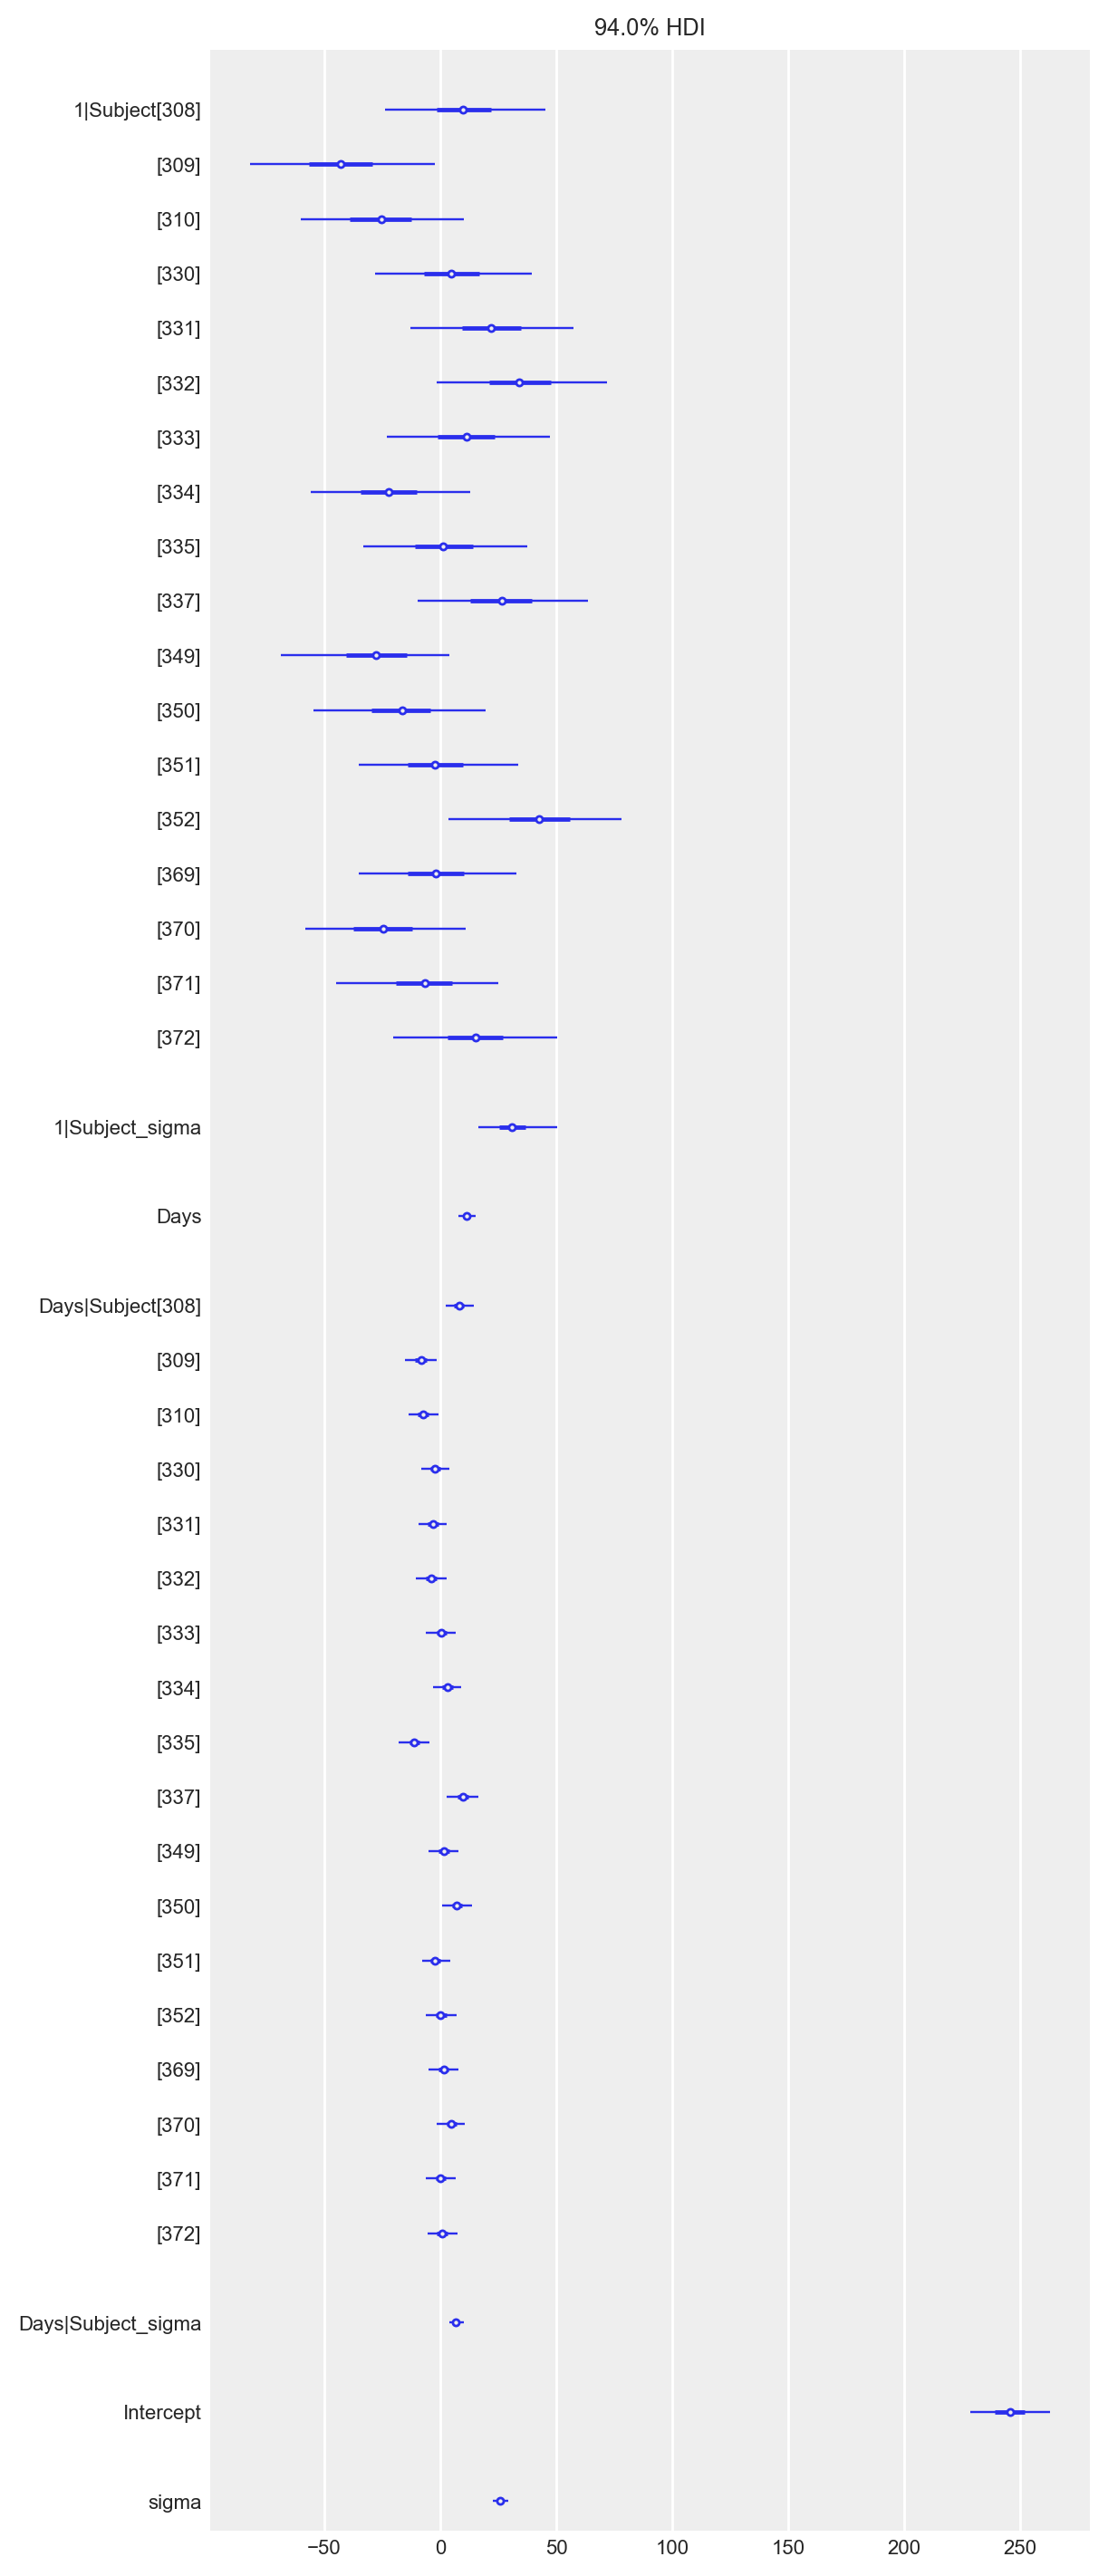

In [21]:
az.plot_forest(data=results_partial_pooling, r_hat=False, combined=True, textsize=8);

In sintesi, il modello gerarchico cattura il comportamento che abbiamo visto nella fase di esplorazione dei dati. Le persone differiscono sia nei tempi di reazione iniziali che nel modo in cui questi tempi di reazione sono influenzati dai giorni di deprivazione del sonno. Possiamo dunque giungere alle seguenti conclusioni:

- Il tempo di reazione medio delle persone aumenta quando sono deprivate del sonno.
- I soggetti hanno tempi di reazione diversi all'inizio dello studio.
- Alcuni soggetti sono più colpiti dalla privazione del sonno rispetto ad altri.
  
Ma c'è un'altra domanda a cui non abbiamo ancora risposto: I tempi di reazione iniziali sono associati a quanto la deprivazione del sonno influisce sull'evoluzione dei tempi di reazione? 

Creiamo un diagramma a dispersione per visualizzare le stime a posteriori congiunte delle intercette e delle pendenze specifiche per i soggetti. Questo grafico usa colori diversi per i soggetti. Se guardiamo il quadro generale, cioè trascurando i ragruppamenti dei dati in base ai soggetti, possiamo concludere che non c'è associazione tra l'intercetta e la pendenza. In altre parole, avere tempi di reazione iniziali più bassi o più alti non dice nulla su quanto la deprivazione del sonno influisca sul tempo di reazione medio di un determinato soggetto.

D'altra parte, se guardiamo la distribuzione a posteriori congiunta per un determinato individuo, possiamo vedere una correlazione negativa tra l'intercetta e la pendenza. Questo indica che, condizionalmente a un determinato soggetto, le stime a posteriori dell'intercetta e della pendenza non sono indipendenti. 

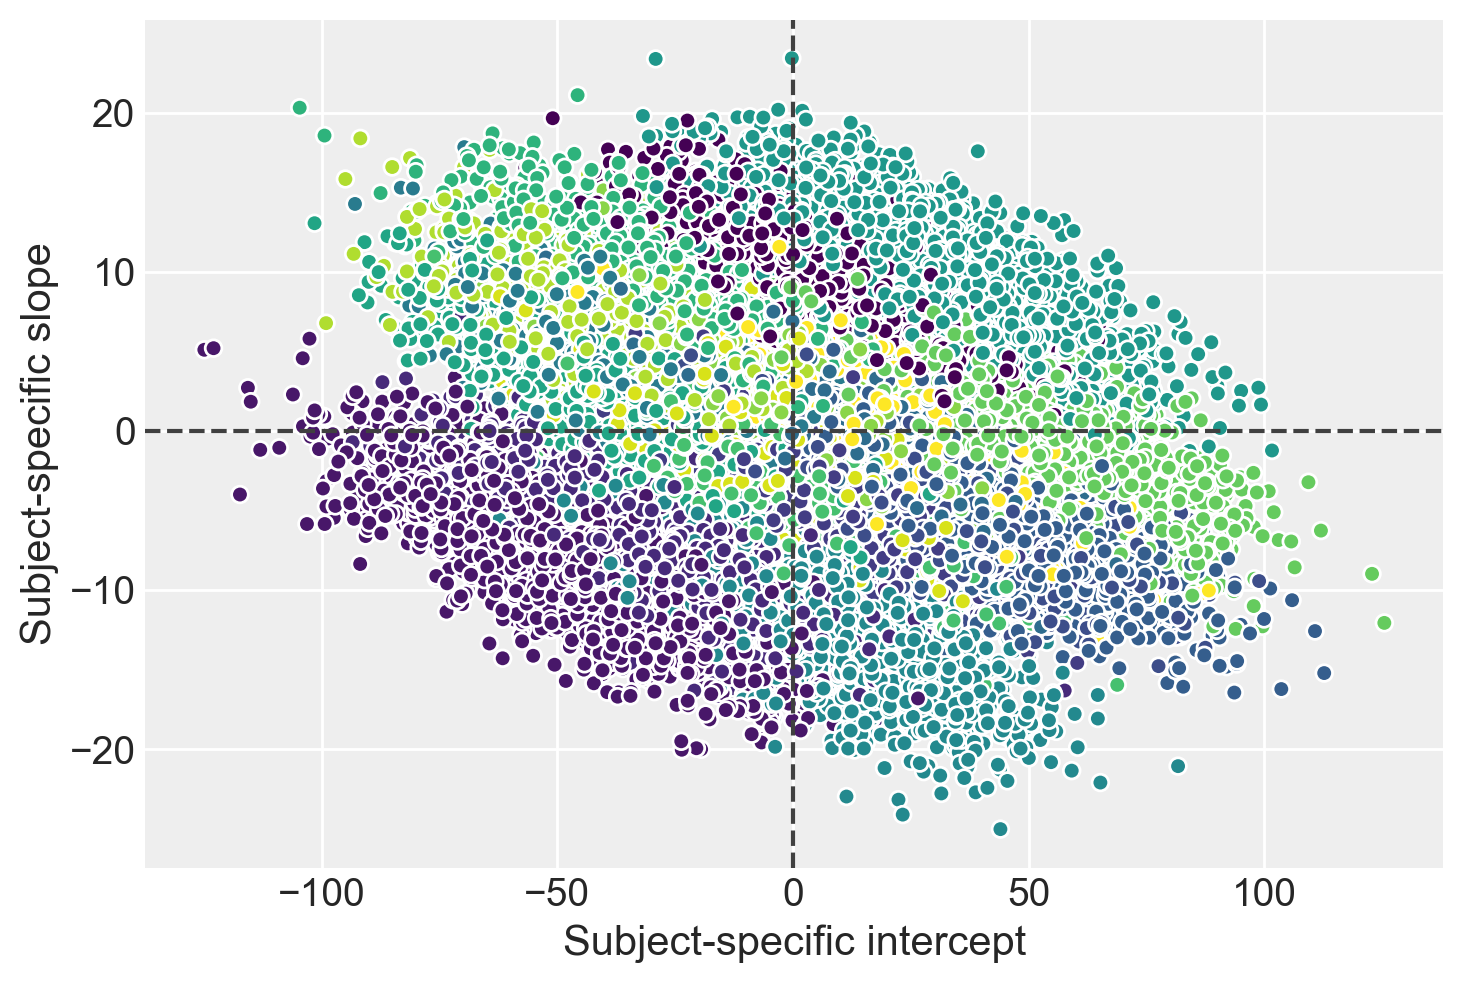

In [22]:
#  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(results_partial_pooling, num_samples=500)

_, ax = plt.subplots()

results_partial_pooling.posterior.plot.scatter(
    x="1|Subject", y="Days|Subject",
    hue="Subject__factor_dim",
    add_colorbar=False,
    add_legend=False,
    edgecolors=None,
)

ax.axhline(c="0.25", ls="--")
ax.axvline(c="0.25", ls="--")
ax.set_xlabel("Subject-specific intercept")
ax.set_ylabel("Subject-specific slope");

## Confronto dei modelli

Un aspetto finale e cruciale del nostro studio riguarda il confronto tra i diversi modelli che abbiamo esaminato. La nostra intenzione è determinare quale modello fornisce una rappresentazione migliore dei dati, trovando un equilibrio appropriato tra l'accuratezza del modello e la sua complessità, cioè la parsimonia.

Per raggiungere questo scopo, faremo uso della metrica ELPD (Expected Log Predictive Density), che abbiamo introdotto in precedenza. ELPD ci consente di valutare un modello in termini di adattamento ai dati, considerando sia l'accuratezza delle previsioni che la complessità del modello.

### Utilizzo di `az.compare()` 

In Python, possiamo sfruttare la funzione `az.compare()` per confrontare direttamente modelli bayesiani. Questa funzione accetta un dizionario contenente gli oggetti `InferenceData`, risultanti dalla funzione `Model.fit()`, e restituisce un dataframe. I modelli vengono ordinati dal migliore al peggiore in base ai criteri selezionati, e di default, ArviZ usa il criterio di convalida incrociata "leave one out" (LOO).

#### Convalida Incrociata "Leave One Out" (LOO)

LOO è una tecnica di convalida che addestra il modello su tutti i dati disponibili tranne uno, utilizzando il singolo punto escluso come dati di test. Questo processo viene ripetuto per ogni punto dati nel set, e la media delle misure di errore fornisce una stima accurata dell'errore di generalizzazione del modello. Anche se computazionalmente impegnativa, LOO fornisce una valutazione affidabile delle prestazioni del modello. In ArviZ, la funzione `loo` implementa questo metodo seguendo un approccio bayesiano.

#### Widely Applicable Information Criterion (WAIC)

Oltre a LOO, possiamo anche utilizzare il criterio WAIC (Widely Applicable Information Criterion). Il WAIC è uno strumento per la selezione del modello che mira a trovare il modello ottimale in un insieme di candidati, equilibrando l'adattamento ai dati e la complessità del modello, evitando così il sovradattamento. WAIC è particolarmente utile nel contesto bayesiano, poiché tiene conto dell'incertezza associata ai parametri del modello.

Sia LOO che WAIC possono essere visti come stime empiriche dell'ELPD, fornendo un quadro comprensivo delle prestazioni dei modelli.

Utilizzando la funzione `az.compare()`, siamo in grado di effettuare una comparazione rapida ed efficace tra i diversi modelli, valutandoli secondo i criteri LOO e WAIC. Nel nostro caso specifico, il modello di "partial pooling" emerge come il migliore, presentando il valore ELPD stimato più alto. Questo risultato conferma la validità del modello nel rappresentare la struttura dei dati, tenendo conto delle differenze individuali all'interno dei cluster, e fornendo una stima coerente e informativa dell'effetto della deprivazione del sonno sul tempo di reazione.

In [23]:
models_dict = {
    "pooling": results_pooling,
    "no_pooling": results_no_pooling,
    "partial_pooling": results_partial_pooling
}
df_compare = az.compare(models_dict)
df_compare

rank    elpd_loo      p_loo  elpd_diff    weight         se  \
partial_pooling     0 -692.203378  31.116753   0.000000  0.945524  21.750623   
no_pooling          1 -694.239760  35.771777   2.036382  0.004772  21.582485   
pooling             2 -772.176595   3.066678  79.973217  0.049704   9.054093   

                       dse  warning scale  
partial_pooling   0.000000     True   log  
no_pooling        3.251708     True   log  
pooling          20.322146    False   log

È importante sottolineare che, per ottenere una stima dell'ELPD (Expected Log Predictive Density), è necessario includere l'opzione `idata_kwargs={"log_likelihood": True}` all'interno della funzione responsabile dell'esecuzione del campionamento MCMC.

La figura che segue illustra visivamente le informazioni rilevanti per il confronto tra i diversi modelli. In grigio è indicata l'incertezza nella stima della differenza tra i valori ELPD dei diversi modelli.

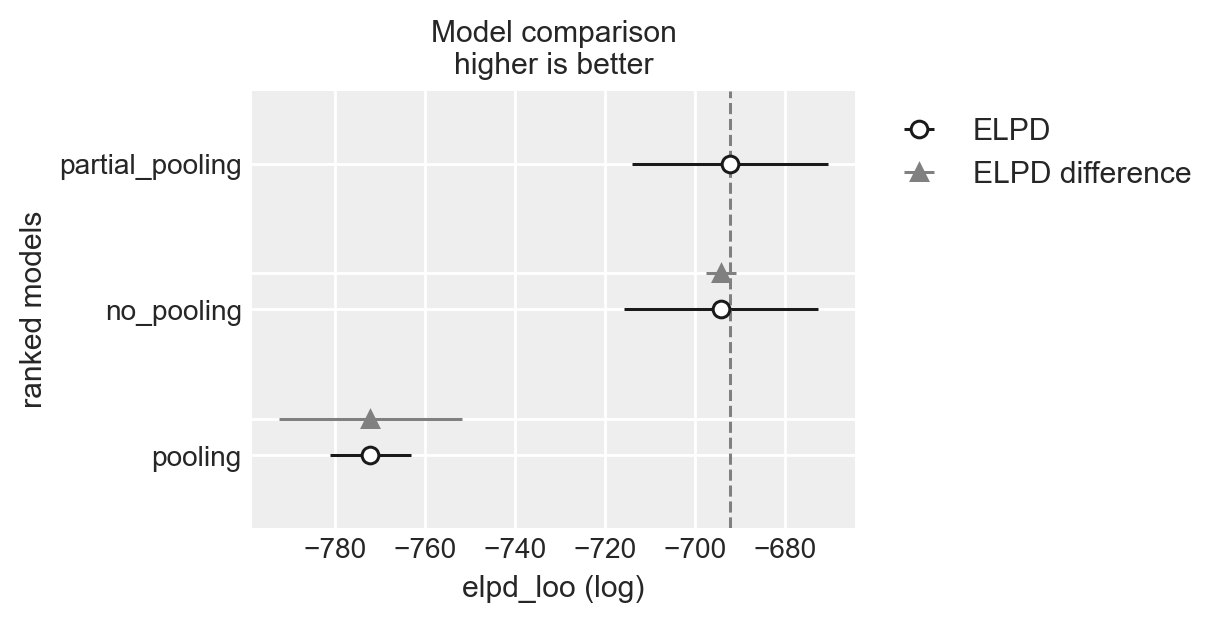

In [24]:
_ = az.plot_compare(df_compare, insample_dev=False)

Il confronto tra i modelli guida il processo di selezione. In particolare, la comparazione tra il modello di partial-pooling e il modello completo di pooling è resa chiara dall'`elpd_diff` di 80.17 e dal suo errore standard di 19.97. Questi valori indicano inequivocabilmente che il modello di partial-pooling è superiore.

La situazione diventa più sfumata quando confrontiamo il modello di partial-pooling con il modello di no-pooling. In questo caso, le stime dell'ELPD mostrano una grande sovrapposizione, suggerendo che non c'è una differenza netta tra i due modelli in termini di adattamento ai dati.

Tuttavia, nonostante la vicinanza dei valori di ELPD, il modello di partial-pooling è da preferire. La ragione risiede nelle sue proprietà: esso fornisce stime più robuste e conservative delle differenze individuali. A differenza del modello di no-pooling, che può essere troppo sensibile alle variazioni all'interno dei cluster, il modello di partial-pooling incorpora un equilibrio tra la condivisione delle informazioni all'interno del gruppo e il riconoscimento delle differenze tra i gruppi. Questo lo rende più resistente alle fluttuazioni nei dati e offre una rappresentazione più affidabile delle relazioni sottostanti, rendendolo la scelta preferibile in questo contesto.

#### PPC plots

Per affrontare il tema della selezione di modelli, @Johnson2022bayesrules usano anche il metodo dei *posterior predictive checks*.  Creiamo dunque i PPC plots per i tre modelli.

In [25]:
model_pooling_fitted = model_pooling.fit(idata_kwargs={"log_likelihood": True})
model_pooling.predict(model_pooling_fitted, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Days]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


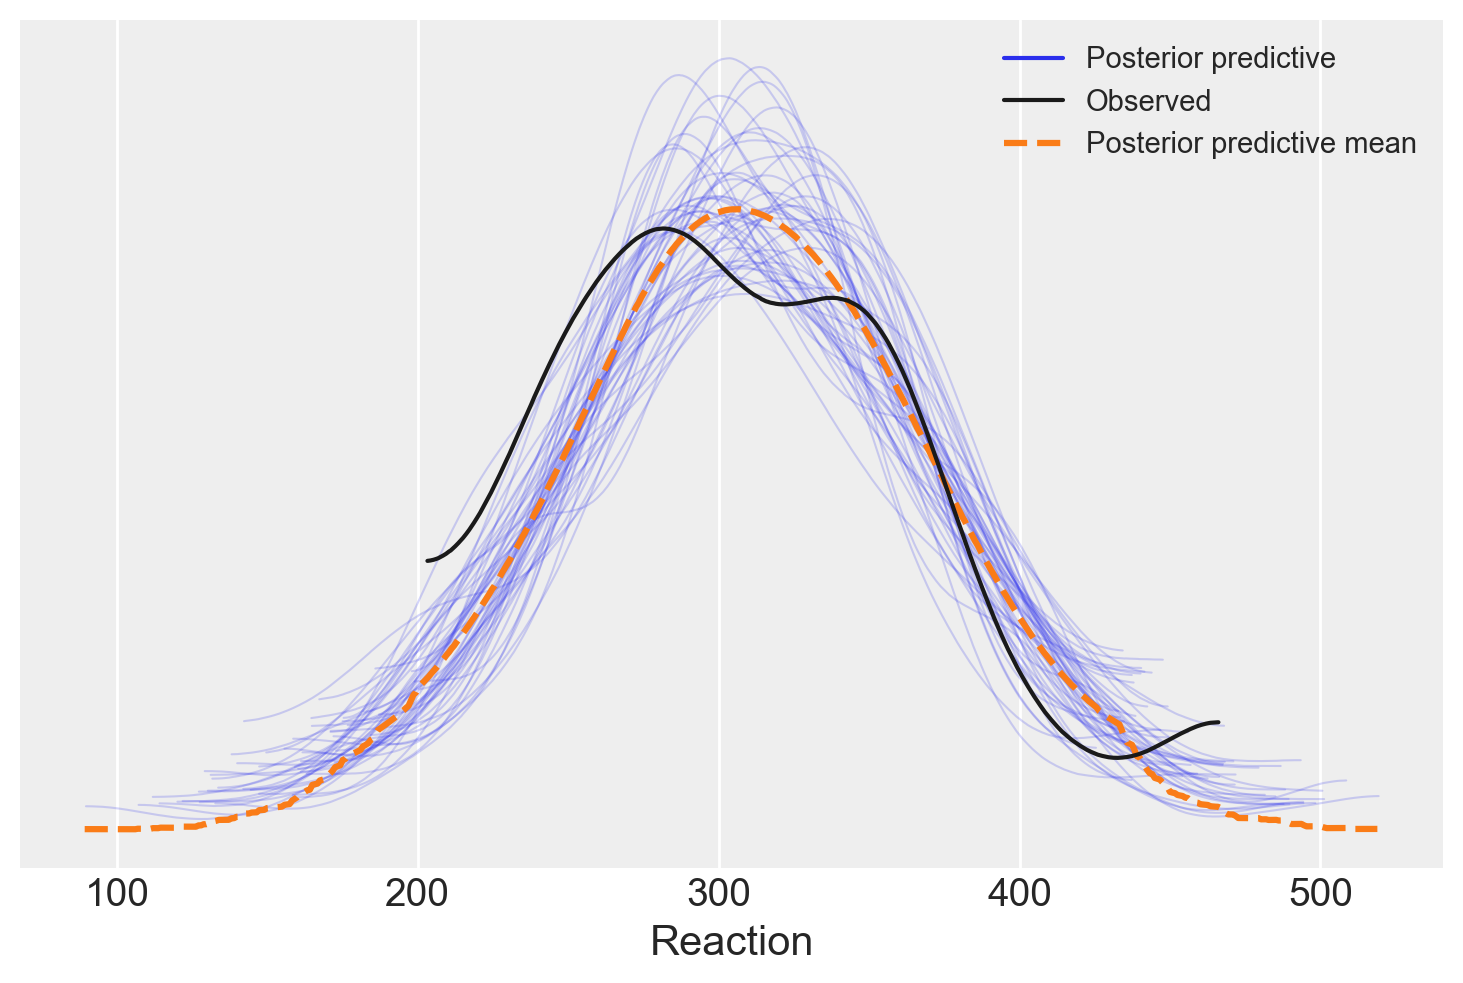

In [27]:
_ = az.plot_ppc(model_pooling_fitted, num_pp_samples=50)

In [28]:
model_no_pooling_fitted = model_no_pooling.fit(idata_kwargs={"log_likelihood": True})
model_no_pooling.predict(model_no_pooling_fitted, kind="pps");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Days, C(Subject), Days:C(Subject)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


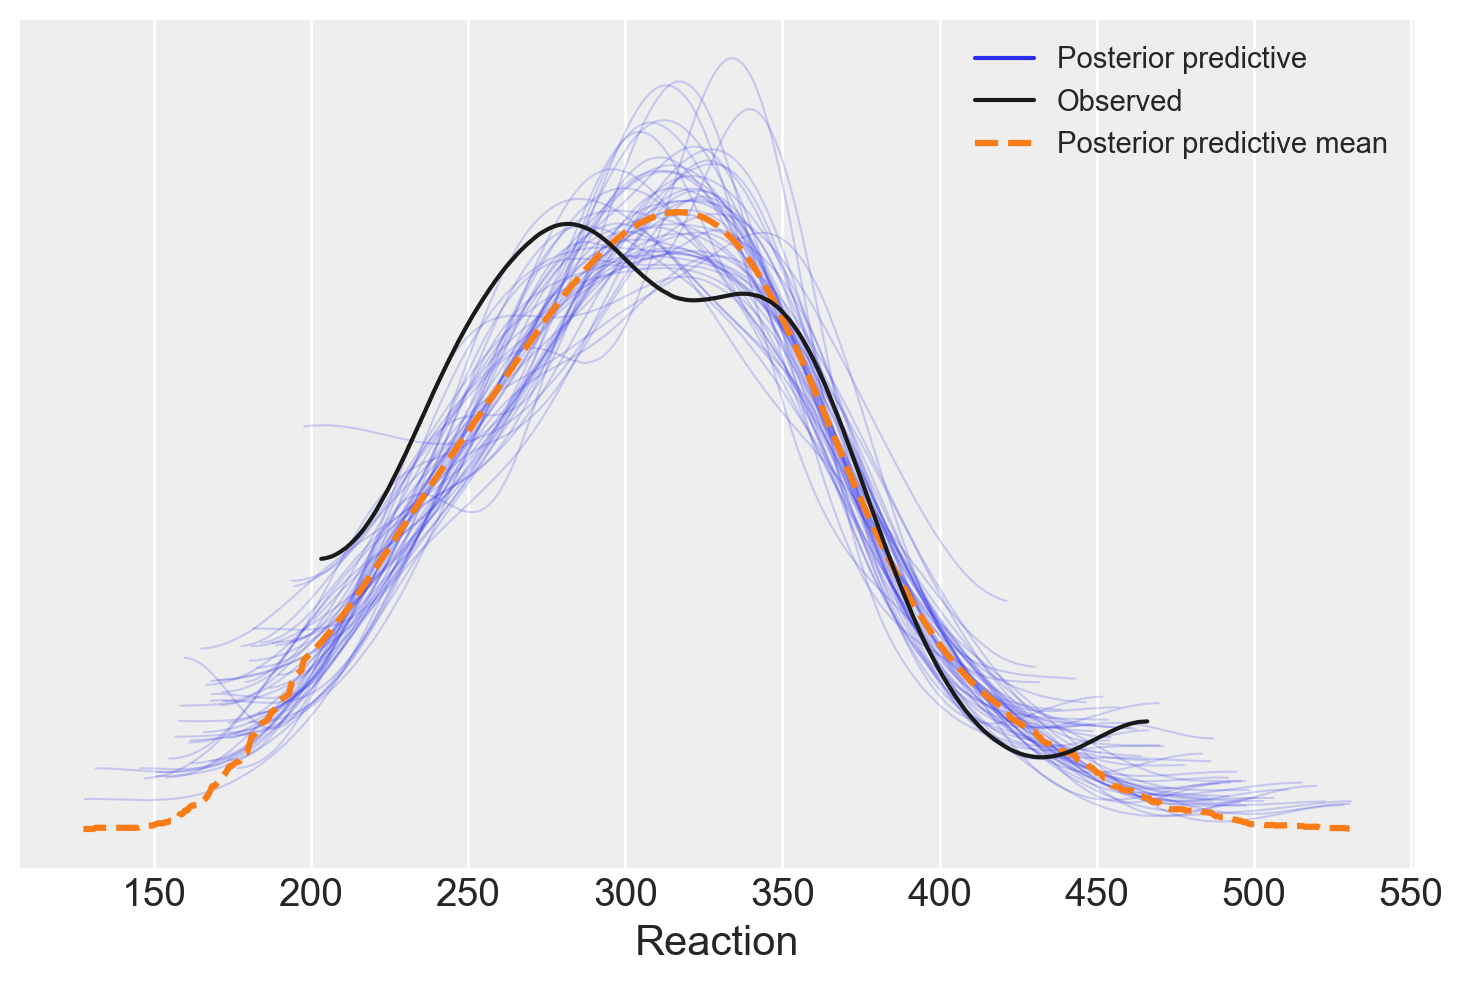

In [29]:
_ = az.plot_ppc(model_no_pooling_fitted, num_pp_samples=50)

In [30]:
model_partial_pooling_fitted = model_partial_pooling.fit(idata_kwargs={"log_likelihood": True})
model_partial_pooling.predict(model_partial_pooling_fitted, kind="pps");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


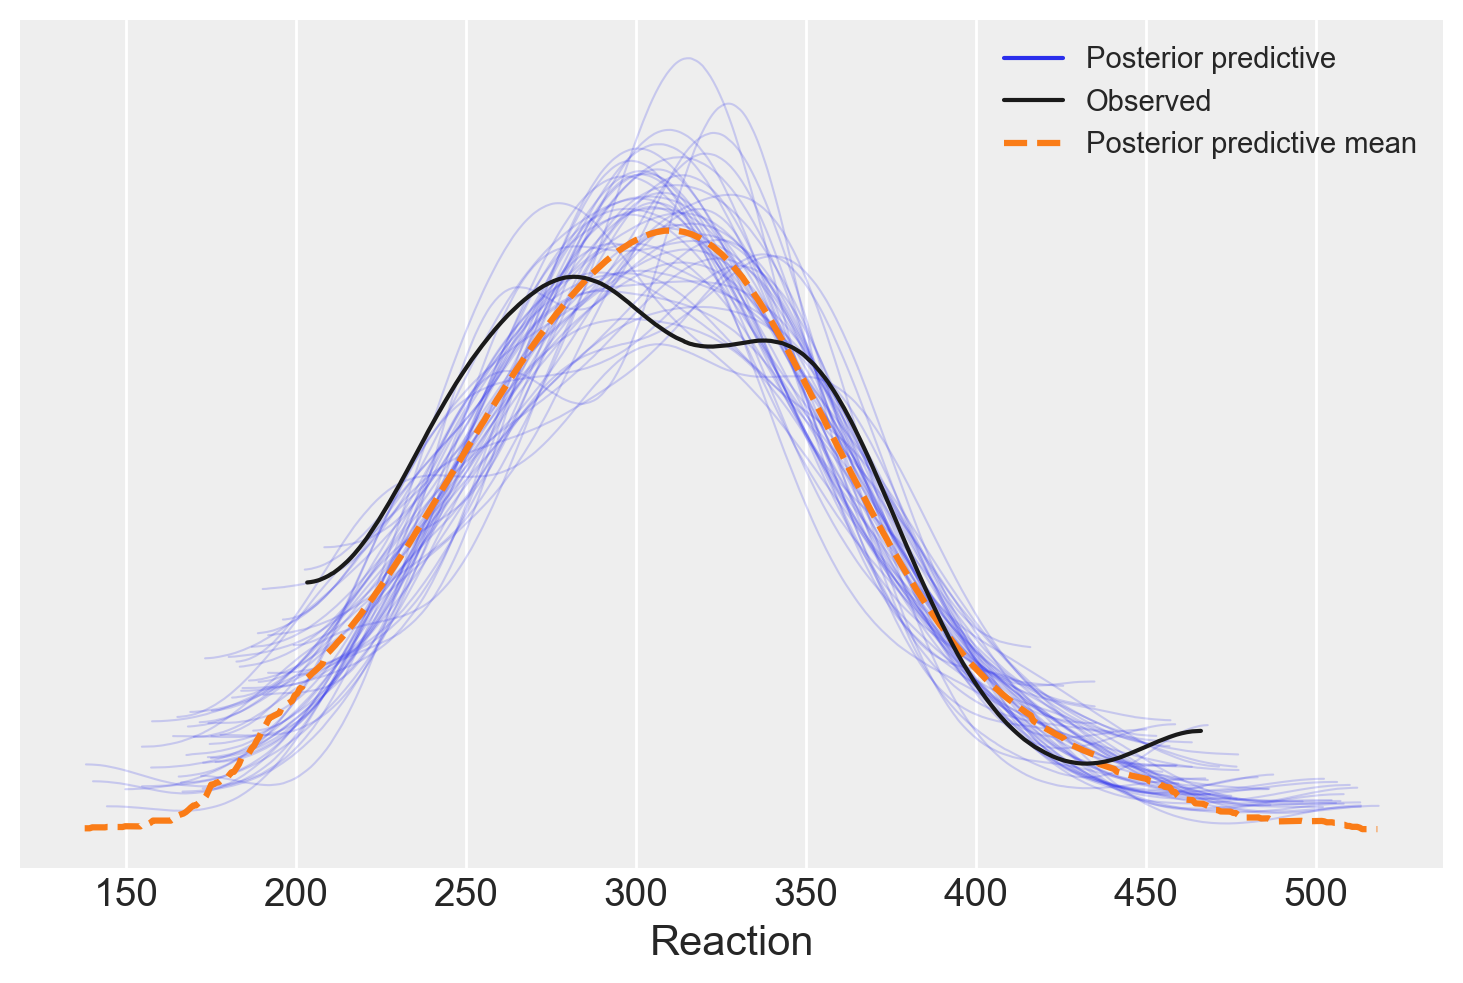

In [31]:
_ = az.plot_ppc(model_partial_pooling_fitted, num_pp_samples=50)

In questo contesto specifico, l'analisi tramite i PPC (Posterior Predictive Checks) plots non rivela differenze evidenti tra i tre modelli in esame: tutti sembrano egualmente adeguati nell'adattarsi ai dati. Di conseguenza, i PPC plots non forniscono ulteriori chiarimenti o conferme alle conclusioni già raggiunte attraverso il confronto tra modelli basato sulla differenza ELPD (Expected Log Predictive Density). In altre parole, l'analisi visiva tramite i PPC plots non aggiunge valore o informazioni supplementari a quanto già dedotto dalle metriche di confronto.

## Quale modello scegliere?

Ritorniamo ora all'articolo di @gelman2024statistical. Questi autori affermano che un lettore ingenuo di molte discussioni sulla crisi della replicazione potrebbe avere l'impressione che tutto andrebbe bene se i ricercatori seguissero semplicemente i protocolli della scienza aperta ed evitassero le pratiche di ricerca disoneste. Tuttavia, i problemi sono più profondi, e uno di essi riguarda le difficoltà nell'analisi statistica dei dati.

@aungle2023physical hanno seguito le raccomandazioni generali di utilizzare la modellazione multilivello quando si analizzano dati raggruppati, ma non si sono resi conto che era necessario permettere agli effetti del trattamento, non solo all'intercetta, di variare tra i partecipanti. @gelman2024statistical se ne sono accorti grazie agli indici t insolitamente alti e perché sono stati in grado di scaricare e interpretare il codice degli autori.

Nell'affrontare l'analisi di dati con struttura multilivello, @gelman2024statistical suggeriscono come approccio ottimale di consentire la variazione sia delle intercette che degli effetti attraverso ogni livello di raggruppamento quando si stima un effetto causale o un coefficiente di regressione. Tuttavia, gli stessi autori riconoscono i limiti pratici di questa strategia. L'inclusione di componenti di varianza aggiuntivi può infatti compromettere la stabilità del modello, specialmente in presenza di campioni ridotti sia in termini di misurazioni che di partecipanti. Questa considerazione evidenzia come, nell'ambito delle ricerche psicologiche caratterizzate spesso da dati complessi, sia necessario un approccio flessibile e contestualizzato, piuttosto che l'applicazione di linee guida universali.

In aggiunta, quando emerge un risultato interessante, secondo @gelman2024statistical è fondamentale consolidarlo attraverso una replicazione esatta [@nosek2012scientific]: 

> When an interesting result arises, nail down the finding by designing and carrying out an exact replication. Contrary to all your expectations, the replication might fail; indeed that is the reason for performing the replication in the first place. 

Questa pratica, oltre a rafforzare la validità delle scoperte, offre l'opportunità di rilevare eventuali falsi positivi, essenziale per il progresso scientifico.

@gelman2024statistical suggeriscono inoltre di progettare nuovi studi basandosi su modelli ipotetici plausibili e di preregistrarli prima della raccolta dati. La fase di progettazione e preregistrazione è un momento opportuno per riflettere attentamente sulle dimensioni degli effetti e sulla loro variazione, nonché per comprendere un disegno sperimentale utilizzando dati simulati [@gelman2024before].

Riconoscendo l'importanza della preregistrazione, diverse riviste stanno aumentando il loro supporto a questa pratica. La forma più rigorosa attualmente disponibile, i Registered Reports, richiede che i piani di analisi statistica prespecificati dagli autori siano rivisti prima dell'inizio della raccolta dati, introducendo uno sguardo esterno e imparziale nel processo. I Registered Reports mostrano un notevole potenziale nella riduzione del bias di pubblicazione [@scheel2021excess].

In conclusione, secondo @gelman2024statistical, la scelta del modello statistico appropriato, la replicazione dei risultati e la preregistrazione degli studi sono elementi cruciali per affrontare le sfide metodologiche nella ricerca psicologica contemporanea.

## Commenti e considerazioni finali 

In questo capitolo, abbiamo esaminato e messo a confronto tre modelli statistici - pooling, no pooling e partial pooling - applicandoli ai dati dello studio sul sonno di Belenky et al. (2003). Ciascun modello presenta caratteristiche distintive:

- il pooling si basa su una struttura comune per tutti i gruppi,
- il no pooling mantiene l'indipendenza tra i gruppi,
- il partial pooling offre un equilibrio tra i due approcci precedenti.

Per selezionare il modello più appropriato, abbiamo utilizzato l'analisi basata sulla differenza della densità predittiva logaritmica attesa (ELPD). Questo metodo fornisce una misura oggettiva della qualità di adattamento, facilitando la scelta del modello che meglio riflette la struttura sottostante dei dati, pur riconoscendo i vantaggi specifici di ciascun approccio.

Al di là delle considerazioni puramente statistiche, i modelli multilivello rivestono un ruolo importante nella discussione sulla crisi della replicabilità dei risultati della ricerca psicologica. @gelman2024statistical offrono diverse utili raccomandazioni a questo proposito, sottolineando come tali modelli possano contribuire a migliorare la robustezza e l'affidabilità delle analisi.

In conclusione, l'adozione di metodologie statistiche avanzate, come la modellazione multilivello, rappresenta un passo cruciale verso una ricerca psicologica più solida. Questi approcci consentono di:

1. cogliere la complessità dei fenomeni studiati,
2. produrre risultati più facilmente replicabili,
3. fornire interpretazioni più accurate e contestualizzate.

L'impiego di tali tecniche, unitamente a una maggiore consapevolezza metodologica, può contribuire significativamente al progresso della disciplina e all'incremento della fiducia nei risultati della ricerca psicologica.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Tue Jul 30 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pingouin  : 0.5.4
arviz     : 0.18.0
matplotlib: 3.9.1
seaborn   : 0.13.2
numpy     : 1.26.4
bambi     : 0.14.0

Watermark: 2.4.3

